In [ ]:
!pip install gcsfs

In [105]:
# For scientific calculations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [106]:
import pandas as pd
import gcsfs

In [107]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

In [108]:
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO

mybucket = storage.Bucket('omina-test-set')
data_csv = mybucket.object('occupancy-data/occupancy_data.csv')

uri = data_csv.uri
%gcs read --object $uri --variable data

df = pd.read_csv(BytesIO(data))
df.head()

,Unnamed: 0,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [109]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

In [110]:
df = df.sort_values(by='date')
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,,
2015-02-02 14:19:00,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,0
2015-02-02 14:19:59,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,0
2015-02-02 14:21:00,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,0
2015-02-02 14:22:00,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,0
2015-02-02 14:23:00,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,0


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


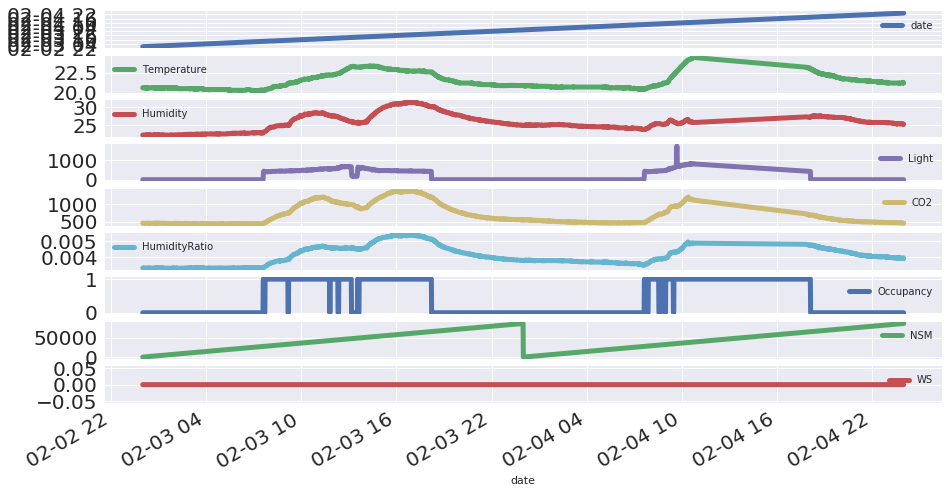

In [112]:
df['2015-02-03' : '2015-02-04'].plot(subplots=True, figsize=(15,8), linewidth=5, fontsize=20)
plt.legend(loc='best')

In [113]:
corr = df.corr()

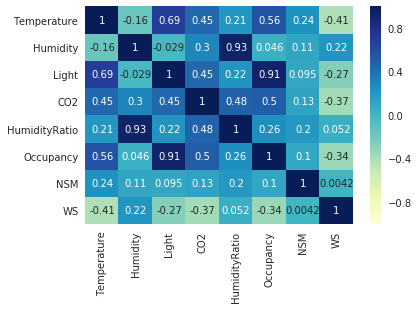

In [114]:
sns.heatmap(corr, annot="True", cmap="YlGnBu")

In [ ]:
sns.pairplot(df)

In [ ]:
y = df["Occupancy"]
X = df.drop("Occupancy", axis=1)

In [ ]:
df.isnull().values.any()

In [ ]:
np.delete(y, s_[0:0], axis=1)

In [ ]:
# #Cross validation on the given data to split the training and test set 
# from sklearn import cross_validation
# from sklearn.cross_validation import train_test_split
# #70% of the total data is used for training
# train_data_length = int(round(len(df.index)*.07))
# print(train_data_length)
# X_train,X_test,y_train,y_test = cross_validation.train_test_split(X, y, train_size= train_data_length) 

In [99]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
TimeSeriesSplit(max_train_size=None, n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

('TRAIN:', array([   0,    1,    2, ..., 5137, 5138, 5139]), 'TEST:', array([ 5140,  5141,  5142, ..., 10277, 10278, 10279]))


KeyError: '[   0    1    2 ... 5137 5138 5139] not in index'

In [79]:
# Random Forest in train data 
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("Mean Accuracy for Random Forest in train data: ", acc_random_forest, "%")

TypeError: float() argument must be a string or a number